In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!ls pyWake/

pywake_FUGA.nc	pywake_linear_bast.nc


In [10]:
!ls foxes/

power_validation_inputs_foxes_1.csv  turbine_data_validation_inputs_foxes_1.nc
power_validation_inputs_foxes_2.csv  turbine_data_validation_inputs_foxes_2.nc
power_validation_inputs_foxes_3.csv  turbine_data_validation_inputs_foxes_3.nc
power_validation_inputs_foxes_A.csv  turbine_data_validation_inputs_foxes_A.nc
power_validation_inputs_foxes_B.csv  turbine_data_validation_inputs_foxes_B.nc
power_validation_inputs_foxes_C.csv  turbine_data_validation_inputs_foxes_C.nc
power_validation_inputs_foxes_D.csv  turbine_data_validation_inputs_foxes_D.nc
power_validation_inputs_foxes_E.csv  turbine_data_validation_inputs_foxes_E.nc
power_validation_inputs_foxes_F.csv  turbine_data_validation_inputs_foxes_F.nc
power_validation_inputs_foxes_G.csv  turbine_data_validation_inputs_foxes_G.nc


In [26]:
!ls WAYVE/

power_windio_les_validation_wayve.csv


In [4]:
pywake_no_blockage = xr.load_dataset('pyWake/pywake_linear_bast.nc')
pywake_blockage = xr.load_dataset('pyWake/pywake_FUGA.nc')

In [11]:
letters = ['1', '2', '3']
foxes_pred = [xr.load_dataset('foxes/turbine_data_validation_inputs_foxes_%s.nc' % letters[ii]) for ii in range(len(letters))]

In [6]:
wayve_dat = pd.read_csv('WAYVE/power_windio_les_validation_wayve.csv')

In [12]:
np.array([wayve_dat.iloc[0].values[1:].max(), 1e3 * foxes_pred[0].isel(state=0).P.values.max(),  pywake_no_blockage.isel(time=0).Power.values.max()]) / 1e6

array([9.19739901, 9.38805978, 9.56215049])

In [13]:
case_num = 3

ok


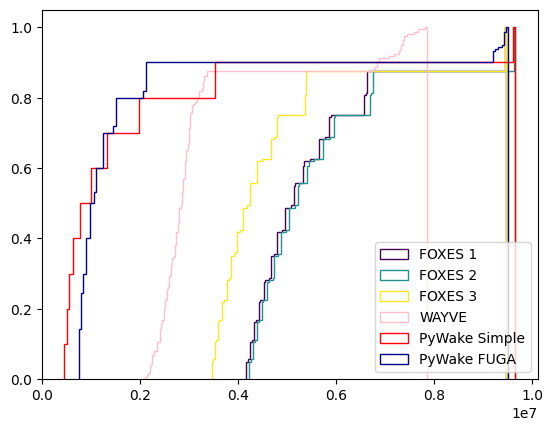

In [14]:
foxes_colors = plt.cm.viridis(np.linspace(0, 1, len(letters)))
pywake_colors = ['red', 'darkblue']

for ll in range(len(letters)):
    plt.hist(foxes_pred[ll].isel(state=case_num).P * 1e3, 200, density=True, cumulative=True, histtype='step', edgecolor=foxes_colors[ll], label='FOXES %s' % letters[ll])
plt.hist(wayve_dat.iloc[case_num].values[1:], 200, cumulative=True, density=True, histtype='step', edgecolor='pink', label='WAYVE')
plt.hist(pywake_no_blockage.isel(time=case_num).Power, 200, density=True, cumulative=True, histtype='step', edgecolor=pywake_colors[0], label='PyWake Simple')
plt.hist(pywake_blockage.isel(time=case_num).Power, 200, density=True, cumulative=True, histtype='step', edgecolor=pywake_colors[1], label='PyWake FUGA')
plt.legend()
print('ok')